In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import nomad.io.base as loader
import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street
import geopandas as gpd

## Load street geometries

In [2]:
streets = gpd.read_file("Streets_Arterials.geojson").to_crs("EPSG:3857")

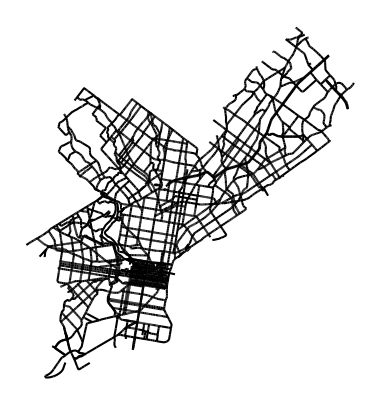

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

streets.plot(ax=ax, edgecolor="black")
plt.show()

## Bounding box for old city

In [4]:
bbox = box(-75.16620602283949, 39.94115823455355, -75.14565573634475, 39.955720193879245)
old_city = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326").to_crs("EPSG:3857")

In [19]:
x_mean, y_mean = old_city.geometry.iloc[0].centroid.xy
x_mean, y_mean = x_mean[0], y_mean[0]

In [21]:
x_mean

-8366319.955610658

## Rotate streets 10 deg, then clip to old city bbox

In [27]:
rot_streets = streets.assign(geometry=streets.geometry.rotate(9, origin=(x_mean, y_mean) ) )
rot_streets = gpd.GeoDataFrame(rot_streets)

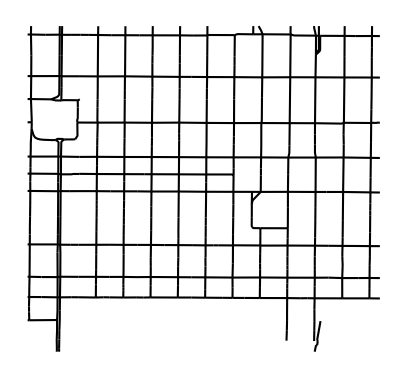

In [51]:
clipped_streets = gpd.clip(rot_streets, old_city)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

clipped_streets.plot(ax=ax,edgecolor="black")

plt.show()

## Simplify and remove weird streets

In [60]:
from shapely.geometry import LineString, LinearRing

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

segments = clipped_streets.geometry.apply(segments)
segments = gpd.GeoSeries([s for seg_list in segments for s in seg_list ])

In [64]:
segments = segments.loc[segments.length>20]

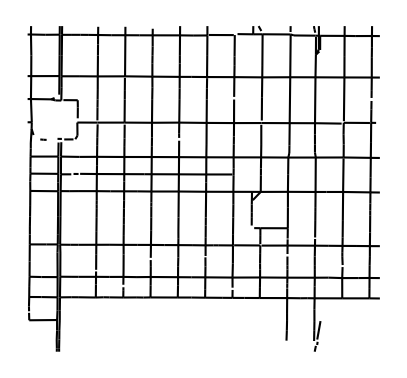

In [65]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

segments.plot(ax=ax,edgecolor="black")

plt.show()

# Parks in PHiladelphia

In [79]:
import requests
from shapely.geometry import box, Point, Polygon
# 1. Define Philly bbox (south, west, north, east)
bbox = (39.94115823455355, -75.16620602283949, 39.955720193879245, -75.14565573634475)

# 2. Overpass QL: get nodes, ways, relations tagged leisure=park
query = f"""
[out:json][timeout:25];
(
  node["leisure"="park"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
  way["leisure"="park"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
  rel["leisure"="park"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
);
out geom;
"""

# 3. Request and parse
url = "https://overpass-api.de/api/interpreter"
resp = requests.post(url, data={"data": query})
data = resp.json()["elements"]

# 4. Build GeoDataFrame
geoms, props = [], []
for el in data:
    if el["type"] == "node":
        geoms.append(Point(el["lon"], el["lat"]))
    else:
        coords = [(pt["lon"], pt["lat"]) for pt in el["geometry"]]
        geoms.append(Polygon(coords))
    props.append({"id": el["id"], **el.get("tags", {})})

gdf = gpd.GeoDataFrame(props, geometry=geoms, crs="EPSG:4326")
gdf.to_file("phl_parks.geojson", driver="GeoJSON")

{'type': 'relation', 'id': 11115686, 'bounds': {'minlat': 39.9454337, 'minlon': -75.1558242, 'maxlat': 39.9554269, 'maxlon': -75.1425561}, 'members': [{'type': 'way', 'ref': 805522112, 'role': 'outer', 'geometry': [{'lat': 39.9486935, 'lon': -75.1468555}, {'lat': 39.9487477, 'lon': -75.1468436}, {'lat': 39.9488293, 'lon': -75.1468256}, {'lat': 39.9493069, 'lon': -75.1467214}, {'lat': 39.9493184, 'lon': -75.146814}, {'lat': 39.9496805, 'lon': -75.1467376}, {'lat': 39.9496865, 'lon': -75.146786}, {'lat': 39.9497172, 'lon': -75.1467794}, {'lat': 39.9500236, 'lon': -75.1467125}, {'lat': 39.9501548, 'lon': -75.1466853}, {'lat': 39.9501479, 'lon': -75.1466241}, {'lat': 39.9501417, 'lon': -75.1465685}, {'lat': 39.9501344, 'lon': -75.1465055}, {'lat': 39.9501327, 'lon': -75.1464917}, {'lat': 39.95013, 'lon': -75.14647}, {'lat': 39.9501233, 'lon': -75.1464018}, {'lat': 39.9501171, 'lon': -75.1463392}, {'lat': 39.9499825, 'lon': -75.1463701}, {'lat': 39.9498913, 'lon': -75.1463908}, {'lat': 39.9

In [77]:
el = data[1]

In [78]:
el

{'type': 'way',
 'id': 25271691,
 'bounds': {'minlat': 39.9491657,
  'minlon': -75.1505497,
  'maxlat': 39.9505422,
  'maxlon': -75.1491346},
 'nodes': [3429163970,
  3408446151,
  775433885,
  3431047125,
  3431047126,
  3431047124,
  3431047134,
  3431047130,
  3431047131,
  2443572312,
  2443572325,
  2443572320,
  3425015325,
  3429163967,
  3429163968,
  3429163969,
  3429163971,
  3429163970],
 'geometry': [{'lat': 39.9505422, 'lon': -75.1502827},
  {'lat': 39.9505003, 'lon': -75.1499575},
  {'lat': 39.9504004, 'lon': -75.1491346},
  {'lat': 39.9501291, 'lon': -75.1491907},
  {'lat': 39.9501039, 'lon': -75.1491959},
  {'lat': 39.9500793, 'lon': -75.149201},
  {'lat': 39.9496546, 'lon': -75.1492888},
  {'lat': 39.9496262, 'lon': -75.1492947},
  {'lat': 39.9496075, 'lon': -75.1492985},
  {'lat': 39.9493607, 'lon': -75.1493495},
  {'lat': 39.9491657, 'lon': -75.1493898},
  {'lat': 39.9491743, 'lon': -75.1494603},
  {'lat': 39.9493066, 'lon': -75.1505497},
  {'lat': 39.9497176, 'lon'